# Fix pathing

In [1]:
import sys


sys.path.append("../..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))))


# Imports

In [3]:
import plotter
import datahandler

import matplotlib.pyplot
import numpy as np
import pandas as pd
import seaborn as sns
import IPython.display
import matplotlib.pyplot as plt
import scipy.stats as stats


# Constants

In [4]:
FOLDER_NAMES = [
    "2024_04_28_09_52_40_CUSTOM_1",
    "2024_04_28_09_52_40_CUSTOM_2",
    "2024_04_28_09_52_40_CUSTOM_3",
    "2024_04_28_09_52_40_CUSTOM_4",
    "2024_04_28_09_52_40_CUSTOM_5",
    "2024_04_28_09_52_40_CUSTOM_6",
    "2024_04_28_09_52_40_CUSTOM_7",
    "2024_04_28_09_52_40_CUSTOM_8",
    "2024_04_28_09_52_40_CUSTOM_9",
    "2024_04_28_09_52_40_CUSTOM_10",
    "2024_04_28_09_52_40_CUSTOM_11",
    "2024_04_28_09_52_40_CUSTOM_12",
]

FOLDER_PATHS = [os.path.join(os.path.dirname(constants.PROJECT_DIRECTORY_PATH), "Simulator", "data", folder_name) for folder_name in FOLDER_NAMES]


In [5]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(False, False, True)


Loading dataset: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


In [6]:
DATE_BOUNDS = [
    ("2016-01-10 07:00:00", "2016-01-10 18:59:59"),
    ("2017-01-10 07:00:00", "2017-01-10 18:59:59"),
    ("2018-01-10 07:00:00", "2018-01-10 18:59:59"),

    ("2016-02-10 07:00:00", "2016-02-10 18:59:59"),
    ("2017-02-10 07:00:00", "2017-02-10 18:59:59"),
    ("2018-02-10 07:00:00", "2018-02-10 18:59:59"),

    ("2016-03-10 07:00:00", "2016-03-10 18:59:59"),
    ("2017-03-10 07:00:00", "2017-03-10 18:59:59"),
    ("2018-03-10 07:00:00", "2018-03-10 18:59:59"),

    ("2016-04-10 07:00:00", "2016-04-10 18:59:59"),
    ("2017-04-10 07:00:00", "2017-04-10 18:59:59"),
    ("2018-04-10 07:00:00", "2018-04-10 18:59:59"),

    ("2016-05-10 07:00:00", "2016-05-10 18:59:59"),
    ("2017-05-10 07:00:00", "2017-05-10 18:59:59"),
    ("2018-05-10 07:00:00", "2018-05-10 18:59:59"),

    ("2016-06-10 07:00:00", "2016-06-10 18:59:59"),
    ("2017-06-10 07:00:00", "2017-06-10 18:59:59"),
    ("2018-06-10 07:00:00", "2018-06-10 18:59:59"),

    ("2016-07-10 07:00:00", "2016-07-10 18:59:59"),
    ("2017-07-10 07:00:00", "2017-07-10 18:59:59"),
    ("2018-07-10 07:00:00", "2018-07-10 18:59:59"),

    ("2016-08-10 07:00:00", "2016-08-10 18:59:59"),
    ("2017-08-10 07:00:00", "2017-08-10 18:59:59"),
    ("2018-08-10 07:00:00", "2018-08-10 18:59:59"),

    ("2016-09-10 07:00:00", "2016-09-10 18:59:59"),
    ("2017-09-10 07:00:00", "2017-09-10 18:59:59"),
    ("2018-09-10 07:00:00", "2018-09-10 18:59:59"),

    ("2016-10-10 07:00:00", "2016-10-10 18:59:59"),
    ("2017-10-10 07:00:00", "2017-10-10 18:59:59"),
    ("2018-10-10 07:00:00", "2018-10-10 18:59:59"),

    ("2016-11-10 07:00:00", "2016-11-10 18:59:59"),
    ("2017-11-10 07:00:00", "2017-11-10 18:59:59"),
    ("2018-11-10 07:00:00", "2018-11-10 18:59:59"),

    ("2016-12-10 07:00:00", "2016-12-10 18:59:59"),
    ("2017-12-10 07:00:00", "2017-12-10 18:59:59"),
    ("2018-12-10 07:00:00", "2018-12-10 18:59:59"),
]


# Methods

In [7]:
def add_response_time(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    return dataframe


In [8]:
def load_csv():
    dfs = [pd.read_csv(os.path.join(folder_path, "events.csv")) for folder_path in FOLDER_PATHS]

    df = pd.concat(dfs, ignore_index=True)

    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    df['total_response_time'] = df[response_time_cols].sum(axis=1)

    return df


In [9]:
def plot_Q_Q_comparison(
    historic_dataframe: pd.DataFrame,
    simulated_dataframe: pd.DataFrame,
    bounds: list[tuple[str, str]] = None,
    triage_impressions: list[str] = ["A", "H", "V1", "ALL"],
    column: str = "duration_resource_appointment"
):
    historic_df = historic_dataframe.copy()
    simulated_df = simulated_dataframe.copy()

    triage_impressions_colors = {
        "A": 0,
        "H": 1,
        "V1": 2,
        "ALL": 7,
    }
    
    if bounds is not None:
        filter_series = pd.Series(False, index=historic_df.index)
        
        for start, end in bounds:
            start_bound = pd.to_datetime(start)
            end_bound = pd.to_datetime(end)
            
            current_filter = (historic_df['time_call_received'] >= start_bound) & (historic_df['time_call_received'] <= end_bound)
            filter_series |= current_filter
        
        historic_df = historic_df[filter_series]

    plt.figure(figsize=(6, 6))

    historic_colors = sns.color_palette()
    simulated_colors = sns.color_palette("pastel")

    for triage_category in triage_impressions:
        # Filter data by triage category
        if triage_category != "ALL":
            historic_data = historic_df[historic_df['triage_impression_during_call'] == triage_category][column].dropna()
            simulated_data = simulated_df[simulated_df['triage_impression_during_call'] == triage_category][column].dropna()
        else:
            historic_data = historic_df[column].dropna()
            simulated_data = simulated_df[column].dropna()

        # Generating quantiles from both datasets
        hist_quantiles = np.sort(stats.zscore(historic_data))
        sim_quantiles = np.sort(stats.zscore(simulated_data))
        
        # Theoretical quantiles
        hist_theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, num=len(historic_data)))
        sim_theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, num=len(simulated_data)))

        # Plotting
        plt.plot(hist_theoretical_quantiles, hist_quantiles, marker='o', linestyle='', color=historic_colors[triage_impressions_colors[triage_category]], label='Historic Data')
        plt.plot(sim_theoretical_quantiles, sim_quantiles, marker='x', linestyle='', color=simulated_colors[triage_impressions_colors[triage_category]], label='Simulated Data')

        # Plot a line y=x for reference
        max_quantile = max(np.max(hist_quantiles), np.max(sim_quantiles))
        min_quantile = min(np.min(hist_quantiles), np.min(sim_quantiles))
        plt.plot([min_quantile, max_quantile], [min_quantile, max_quantile], color='black', linestyle='-', linewidth=2)
        
    matplotlib.pyplot.title('Q-Q Plot Comparison')
    matplotlib.pyplot.xlabel('Theoretical Quantiles')
    matplotlib.pyplot.ylabel('Data Quantiles')
    matplotlib.pyplot.legend()
    plt.grid(True)
    matplotlib.pyplot.show()


In [10]:
def print_mean_median(df: pd.DataFrame):
    stats = df.groupby(['triage_impression_during_call', 'urban'])['total_response_time'].agg(['mean', 'median']).reset_index()
    stats['mean'] = (stats['mean'] / 60).round(2)
    stats['median'] = (stats['median'] / 60).round(2)
    stats.rename(columns={
        'triage_impression_during_call': 'Triage',
        'mean': 'Mean (min)',
        'median': 'Median (min)',
        'urban': 'Urban'
    }, inplace=True)
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})
    stats.sort_values(by=["Urban", "Triage"], ascending=[False, True], inplace=True)
    IPython.display.display(stats.style.hide(axis='index'))


In [11]:
def boxplot_time_at_steps(
    historic_dataframe: pd.DataFrame,
    simulated_dataframe: pd.DataFrame,
    bounds: list[tuple[str, str]] = None,
    triage_impressions: list[str] = ["A", "H", "V1"],
    steps_to_show: list[str] = [
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_dispatching_to_scene",
        "duration_at_scene",
        "duration_dispatching_to_hospital",
        "duration_at_hospital"
    ],
    space_between_sim_his: float = 0.75,
    space_between_step: float = 1.0,
    ylim: tuple[float, float] = None,
    xlim: float = None
):
    historic_df = historic_dataframe.copy()
    simulated_df = simulated_dataframe.copy()
    
    # filter historic data by time frame
    if bounds is not None:
        filter_series = pd.Series(False, index=historic_df.index)
        
        for start, end in bounds:
            start_bound = pd.to_datetime(start)
            end_bound = pd.to_datetime(end)
            
            current_filter = (historic_df['time_call_received'] >= start_bound) & (historic_df['time_call_received'] <= end_bound)
            filter_series = filter_series | current_filter
        
        historic_df = historic_df[filter_series]

    # calculate duration at each stage in minutes (simulated dataframe already has this calculated)
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    step_to_label = {
        "duration_incident_creation": "Incident Creation",
        "duration_resource_appointment": "Resource Appointment",
        "duration_resource_preparing_departure": "Turnout Time",
        "duration_dispatching_to_scene": "Scene Travel Time",
        "duration_at_scene": "Scene Time",
        "duration_dispatching_to_hospital": "Hospital Travel Time",
        "duration_at_hospital": "Handover Time"
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            historic_df.loc[historic_df[times[1]].isna(), step] = (historic_df[times[2]] - historic_df[times[0]]).dt.total_seconds() / 60
            historic_df.loc[~historic_df[times[1]].isna(), step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
        else:
            historic_df[step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
    
    # convert seconds to minutes and replace zeros in simulated data to nan
    for step in historic_steps.keys():
        simulated_df[step] /= 60

    # plot data
    matplotlib.pyplot.figure(figsize=(6, 6))

    data = []
    positions = []
    labels = []
    colors = []
    stripes = []

    i = 0
    for step in historic_steps.keys():
        if step not in steps_to_show:
            continue

        labels.append(f"{step_to_label[step]}")
        for triage in triage_impressions:
            for df, stripe, palette in zip([historic_df, simulated_df], [False, True], [None, "pastel"]):
                data.append(df[df['triage_impression_during_call'] == triage][step].dropna())

                labels.append("")

                if (triage == "A"):
                    colors.append(sns.color_palette(palette)[0])
                elif (triage == "H"):
                    colors.append(sns.color_palette(palette)[1])
                else:
                    colors.append(sns.color_palette(palette)[2])

                stripes.append(stripe)

                positions.append(i)
                i += space_between_sim_his
        labels.pop()
        i += space_between_step

    bplot = matplotlib.pyplot.boxplot(
        data[::-1],
        labels=labels[::-1],
        positions=positions,
        vert=False,
        patch_artist=True,
        showfliers=False
    )

    for patch, color, stripe in zip(bplot["boxes"], colors[::-1], stripes[::-1]):
        patch.set_facecolor(color)

    if ylim is not None:
        matplotlib.pyplot.ylim(ylim)
    if xlim is not None:
        matplotlib.pyplot.xlim(left=-3.5, right=xlim)
    matplotlib.pyplot.title("Comparison of Historical and Synthetic Data Distributions")
    matplotlib.pyplot.xlabel("Time (minutes)")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


In [12]:
def boxplot_time_at_steps_all(
    historic_dataframe: pd.DataFrame,
    simulated_dataframe: pd.DataFrame,
    bounds: list[tuple[str, str]] = None,
    steps_to_show: list[str] = [
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_dispatching_to_scene",
        "duration_at_scene",
        "duration_dispatching_to_hospital",
        "duration_at_hospital"
    ],
    space_between_sim_his: float = 0.75,
    space_between_step: float = 1.0,
    ylim: tuple[float, float] = None
):
    historic_df = historic_dataframe.copy()
    simulated_df = simulated_dataframe.copy()
    
    # filter historic data by time frame
    if bounds is not None:
        filter_series = pd.Series(False, index=historic_df.index)
        
        for start, end in bounds:
            start_bound = pd.to_datetime(start)
            end_bound = pd.to_datetime(end)
            
            current_filter = (historic_df['time_call_received'] >= start_bound) & (historic_df['time_call_received'] <= end_bound)
            filter_series = filter_series | current_filter
        
        historic_df = historic_df[filter_series]

    # calculate duration at each stage in minutes (simulated dataframe already has this calculated)
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    step_to_label = {
        "duration_incident_creation": "Incident Creation",
        "duration_resource_appointment": "Resource Appointment",
        "duration_resource_preparing_departure": "Turnout Time",
        "duration_dispatching_to_scene": "Scene Travel Time",
        "duration_at_scene": "Scene Time",
        "duration_dispatching_to_hospital": "Hospital Travel Time",
        "duration_at_hospital": "Handover Time"
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            historic_df.loc[historic_df[times[1]].isna(), step] = (historic_df[times[2]] - historic_df[times[0]]).dt.total_seconds() / 60
            historic_df.loc[~historic_df[times[1]].isna(), step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
        else:
            historic_df[step] = (historic_df[times[1]] - historic_df[times[0]]).dt.total_seconds() / 60
    
    # convert seconds to minutes and replace zeros in simulated data to nan
    for step in historic_steps.keys():
        simulated_df[step] /= 60

    # plot data
    matplotlib.pyplot.figure(figsize=(6, 6))

    data = []
    positions = []
    labels = []
    colors = []
    stripes = []

    i = 0
    for step in historic_steps.keys():
        if step not in steps_to_show:
            continue

        labels.append(f"{step_to_label[step]}")
        for df, stripe, palette in zip([historic_df, simulated_df], [False, True], [None, "pastel"]):
            data.append(df[step].dropna())
            labels.append("")

            colors.append(sns.color_palette(palette)[7])

            stripes.append(stripe)

            positions.append(i)
            i += space_between_sim_his
        labels.pop()
        i += space_between_step

    bplot = matplotlib.pyplot.boxplot(
        data[::-1],
        labels=labels[::-1],
        positions=positions,
        vert=False,
        patch_artist=True,
        showfliers=False
    )

    for patch, color, stripe in zip(bplot["boxes"], colors[::-1], stripes[::-1]):
        patch.set_facecolor(color)

    if ylim is not None:
        matplotlib.pyplot.ylim(ylim)
    matplotlib.pyplot.title("Comparison of Historical and Synthetic Data Distributions")
    matplotlib.pyplot.xlabel("Time (minutes)")
    matplotlib.pyplot.xticks()
    matplotlib.pyplot.show()


# Main

In [13]:
data_loader.enhanced_incidents_df = add_response_time(data_loader.enhanced_incidents_df)


In [14]:
df = load_csv()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time_call_received                     2446 non-null   object 
 1   triage_impression_during_call          2446 non-null   object 
 2   grid_id                                2446 non-null   int64  
 3   urban                                  2446 non-null   bool   
 4   allocation_index                       2446 non-null   int64  
 5   ambulance_id                           2446 non-null   int64  
 6   dispatched_from_depot_index            2446 non-null   int64  
 7   duration_incident_creation             2446 non-null   int64  
 8   duration_resource_appointment          2446 non-null   int64  
 9   duration_resource_preparing_departure  2446 non-null   int64  
 10  duration_dispatching_to_scene          0 non-null      float64
 11  dura

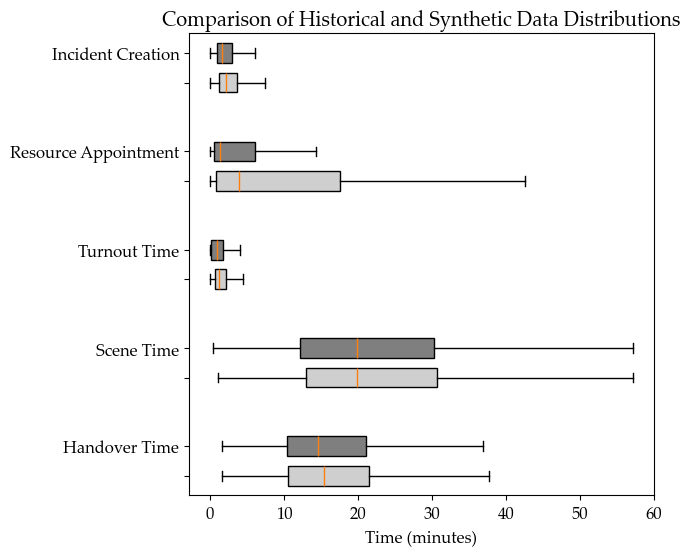

In [15]:
boxplot_time_at_steps_all(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    steps_to_show=[
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_at_scene",
        "duration_at_hospital"
    ]
)


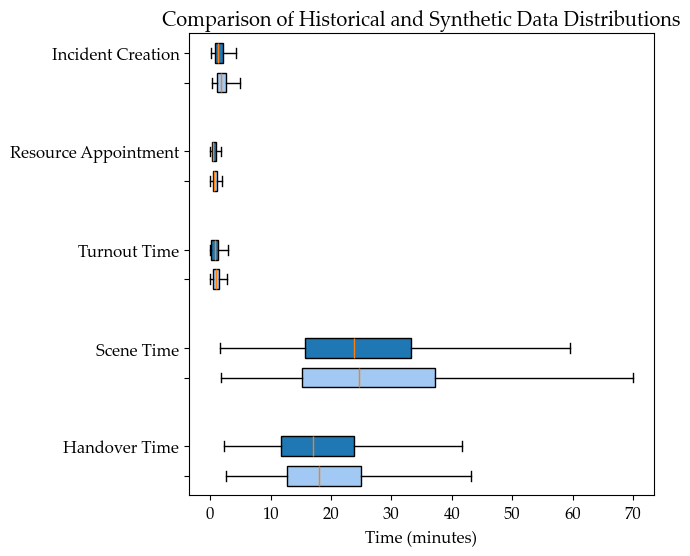

In [16]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["A"],
    steps_to_show=[
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_at_scene",
        "duration_at_hospital"
    ]
)


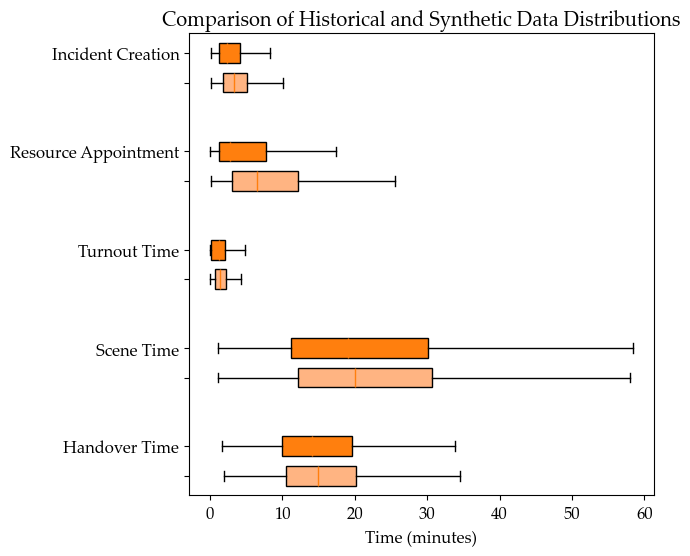

In [17]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["H"],
    steps_to_show=[
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_at_scene",
        "duration_at_hospital"
    ]
)


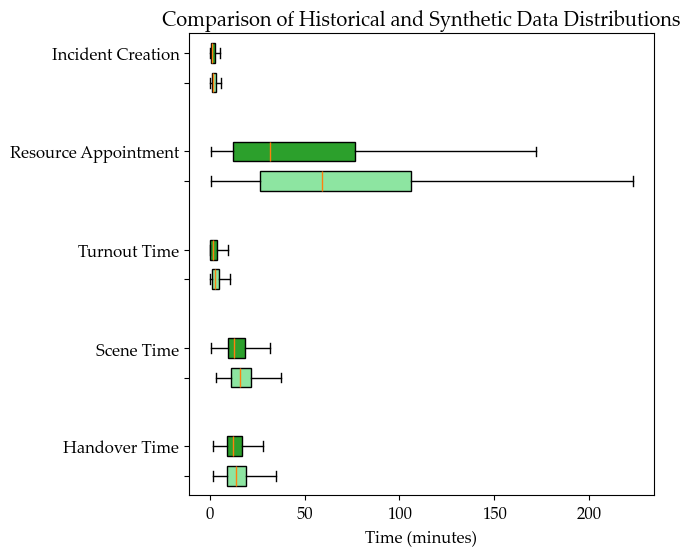

In [18]:
boxplot_time_at_steps(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["V1"],
    steps_to_show=[
        "duration_incident_creation",
        "duration_resource_appointment",
        "duration_resource_preparing_departure",
        "duration_at_scene",
        "duration_at_hospital"
    ]
)


In [19]:
steps_to_show: list[str] = [
    "duration_incident_creation",
    "duration_resource_appointment",
    "duration_resource_preparing_departure",
    "duration_dispatching_to_scene",
    "duration_at_scene",
    "duration_dispatching_to_hospital",
    "duration_at_hospital"
]
column = "duration_at_scene"

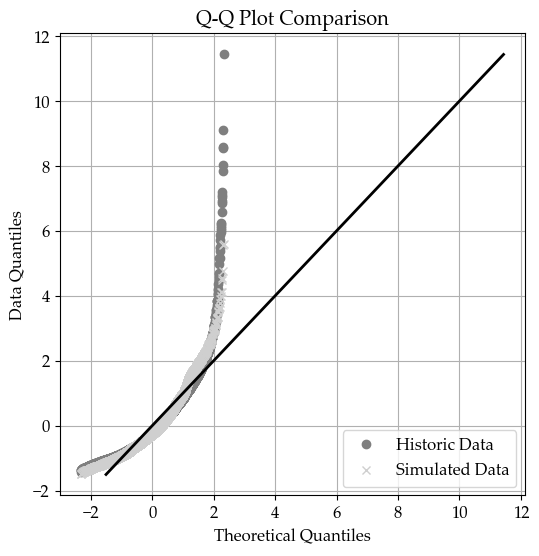

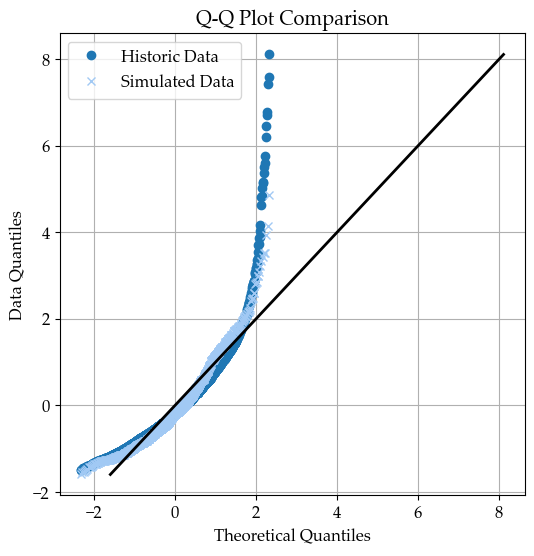

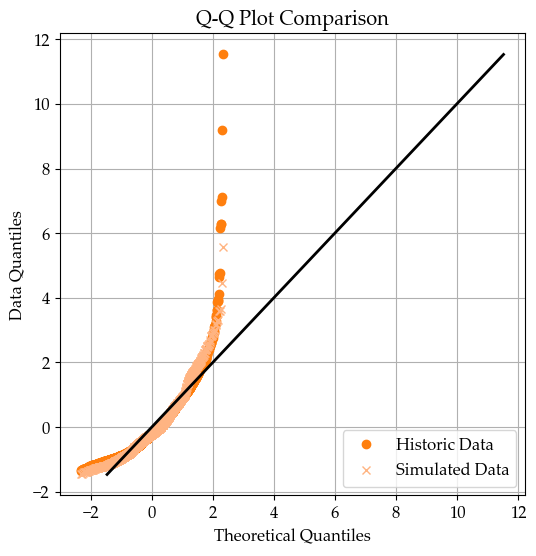

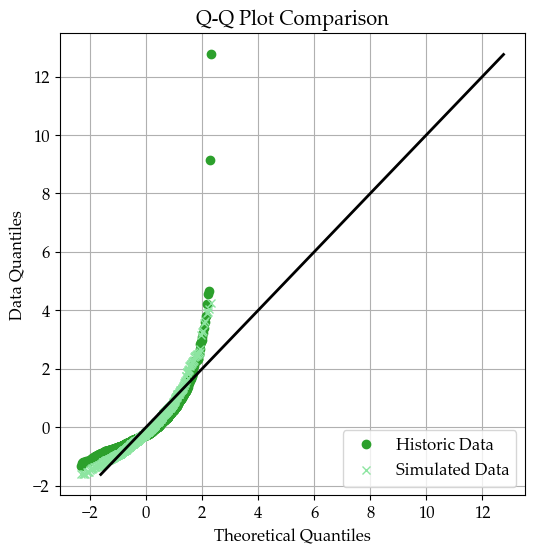

In [20]:
plot_Q_Q_comparison(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["ALL"],
    column=column
)

plot_Q_Q_comparison(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["A"],
    column=column
)

plot_Q_Q_comparison(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["H"],
    column=column
)

plot_Q_Q_comparison(
    historic_dataframe=data_loader.enhanced_incidents_df,
    simulated_dataframe=df,
    bounds=DATE_BOUNDS,
    triage_impressions=["V1"],
    column=column
)



In [21]:
print_mean_median(df)


Triage,Urban,Mean (min),Median (min)
A,Yes,4.090000,3.750000
H,Yes,16.050000,12.250000
V1,Yes,92.110000,62.970000
A,No,4.190000,3.900000
H,No,13.950000,11.670000
V1,No,91.880000,82.850000
